#  Optimización de funciones usando PSO (Particle Swarm Optimization)
 Daniel Saromo (daniel.saromo@pucp.pe )

## Codificación
Se pide completar las secciones de código delimitadas con `## TO DO ##`

In [14]:
#@title Instalación de librerías requeridas
import numpy as np
import random
import warnings
import random
import copy
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
!pip install plotly_express
import plotly.graph_objects as dsm
import plotly_express as px
%matplotlib inline

### Clase Partícula

In [15]:
class Particula:
    """Clase Particula para almacenar informacion de una particula en PSO """
    
    def __init__(self, n_variables, limites_inf=None, limites_sup=None,
                 aleatorioEsEscalar=True):

        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Número de variables de la partícula
        self.n_variables = n_variables
        # Posición de la partícula
        self.posicion = np.repeat(None, self.n_variables)
        # Velocidad de la parícula
        self.velocidad = np.repeat(None, self.n_variables)
        # Valor de la partícula
        self.valor = np.repeat(None, 1)
        # Mejor valor que ha obtenido la partícula hasta el momento
        #(no necesariamente es el valor más alto)
        self.mejor_valor = None
        # Posicion de la particula en la cual obtuvo su mejor valor
        self.mejor_posicion = None

        #Esta variable indica si los vectores aleatorios (para esta particula) 
        #dentro del aprendizaje cognitivo y social son escalares
        #(como se presenta en INF265) o no
        self.aleatorioEsEscalar = True
        
        # Si limites_inf o limites_sup no son un numpy array, son convertidos a dicho tipo
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf,np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)
        
  
        if self.limites_inf is not None \
        and len(self.limites_inf) != self.n_variables:
            raise Exception(
                "limites_inf debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_inf = [10, None, 5]"
                )
        elif self.limites_sup is not None \
        and len(self.limites_sup) != self.n_variables:
            raise Exception(
                "limites_sup debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_sup = [10, None, 5]"
                )
        elif (self.limites_inf is None) or (self.limites_sup is None):
            warnings.warn(
                "Es altamente recomendable indicar los límites dentro de los " + 
                "cuales debe buscarse la solución de cada variable. " + 
                "Por defecto se emplea [-10^3, 10^3]."
                )
        elif any(np.concatenate((self.limites_inf, self.limites_sup)) == None):
            warnings.warn(
                "Los límites empleados por defecto cuando no se han definido " +
                "son: [-10^3, 10^3]."
            )


        # Si no se especifica limites_inf, el valor mínimo que pueden tomar las 
        # variables es -10^3.
        if self.limites_inf is None:
            self.limites_inf = np.repeat(-10**3, self.n_variables)

        # Si no se especifica limites_sup, el valor máximo que pueden tomar las 
        # variables es 10^3.
        if self.limites_sup is None:
             self.limites_sup = np.repeat(+10**3, self.n_variables)
            
        # Si los límites no son nulos, se reemplazan aquellas posiciones None por
        # el valor por defecto -10^3 y 10^3.
        if self.limites_inf is not None:
            self.limites_inf[self.limites_inf == None] = -10**3
           
        if self.limites_sup is not None:
            self.limites_sup[self.limites_sup == None] = +10**3
        
        # Bucle para asignar posición inicial
        for i in np.arange(self.n_variables):
        # Para cada posición, se genera un valor aleatorio dentro del rango
        # permitido para esa dicho componente escalar.
            self.posicion[i] = random.uniform(
                                    self.limites_inf[i],
                                    self.limites_sup[i]
                                )
        ## TO DO ##
        # Cuál es la velocidad inicial de una partícula en PSO?
        componente_escalar_velocidad = 0
        ###########
        self.velocidad = np.repeat(componente_escalar_velocidad, self.n_variables)

    
    def evaluar_particula(self, funcion_objetivo, optimizacion):
        """
        Esta función evalua la partícula calculando el valor que toma la función
        objetivo en la posición en la que se encuentra. Además, compara si la
        nueva posición es mejor que las anteriores. Modifica los atributos
        valor, mejor_valor y mejor_posicion de cada partícula.
        
        """

        # Solo se permite maximizar o minimizar
        if not optimizacion in ["maximizar", "minimizar"]:
            raise Exception(
                "El argumento optimizacion debe ser: 'maximizar' o 'minimizar'"
                )

        # Evaluamos la función objetivo
        self.valor = funcion_objetivo(*self.posicion)

        # Best valor y posición
        # ----------------------------------------------------------------------
        # Se compara el valor actual con el mejor valor histórico. La comparación
        # es distinta dependiendo de si se desea maximizar o minimizar.
        # Si no existe ningún valor histórico, se almacena el actual. Si ya 
        # existe algún valor histórico se compara con el actual y, de ser mejor 
        # este último, se sobrescribe.
        
        if self.mejor_valor is None:
            self.mejor_valor    = np.copy(self.valor)
            self.mejor_posicion = np.copy(self.posicion)
        else:
            if optimizacion == "minimizar":
                if self.valor < self.mejor_valor:
                    self.mejor_valor    = np.copy(self.valor)
                    self.mejor_posicion = np.copy(self.posicion)
            else:
                if self.valor > self.mejor_valor:
                    self.mejor_valor    = np.copy(self.valor)
                    self.mejor_posicion = np.copy(self.posicion)

    def mover_particula(self, mejor_p_enjambre, inercia=0.5, peso_cognitivo=2,
                        peso_social=2, aleatorioEsEscalar=True):
        """
        Este método ejecuta el movimiento de una partícula, lo que implica
        también actualizar su velocidad y posición. No se permite que la partícula
        salga de la zona de búsqueda acotada por los límites para cada dimensión escalar
        de las posiciones vectoriales.
        
        """

        # Actualización de la velocidad
        componente_velocidad = inercia * self.velocidad
        self.aleatorioEsEscalar = aleatorioEsEscalar
        #Se debe indicar si aleatorioEsEscalar, al momento de realizar cada optimización

        ## TO DO ##
        """Esta parte debe ser implementada. Se debe calcular 'nueva_velocidad' de dos maneras,
        dependiendo del valor booleano de 'aleatorioEsEscalar'. El código debe funcionar para
        partículas de cualquier dimensión (no solamente en dos dimensiones), caso contrario,
        no se colocará el puntaje completo para esta sección del código.

        Además, se pide realizar una modificación a la versión clásica de PSO mostrada en clase.
        Al momento de calcular el componente social y el componente cognitivo, se pide que los
        números aleatorios no necesariamente sean escalares, sino que mediante el flag
        'aleatorioEsEscalar', estos valores puedan ser un vector n-dimensional (siendo 'n',
        el número de dimensiones del espacio vectorial de búsqueda del algoritmo).

        Para su implementación, puede seguir la siguiente estructura:
        Si(self.aleatorioEsEscalar== True):
          Los valores aleatorios que se usan como factores multiplicativos para calcular el 
          componente cognitivo de cada partícula, son ESCALARES.

        Sino:
          Los valores aleatorios que se usan como factores multiplicativos para calcular el 
          componente cognitivo de cada partícula, son VECTORES del mismo tamaño que self.velocidad.
          Se debe ejecutar una multiplicación elemento a elemento.

        Sugerencia: Utilizar la generación de números aleatorios de la librería numpy.
        
        ESQUEMA BLACK-BOX DEL CÓDIGO A IMPLEMENTAR:

        IN: componente_velocidad, aleatorioEsEscalar, self.velocidad, peso_cognitivo, peso_social, self.mejor_posicion,
        mejor_p_enjambre, self.posicion

        OUT: nueva_velocidad
        """
        

        if(self.aleatorioEsEscalar== True):
          longVectoresAleat = 1
        else:
          longVectoresAleat=len(self.velocidad)

        r1 = np.random.uniform(low=0.0, high=1.0, size = longVectoresAleat)
        r2 = np.random.uniform(low=0.0, high=1.0, size = longVectoresAleat)
        componente_cognitivo = peso_cognitivo * r1 * (self.mejor_posicion \
                                                      - self.posicion)
        componente_social = peso_social * r2 * (mejor_p_enjambre \
                                                - self.posicion)
        nueva_velocidad = componente_velocidad + componente_cognitivo \
                          + componente_social
        ###########
        self.velocidad = np.copy(nueva_velocidad)
        

        ## TO DO ##
        # Actualizar la posición, considerando la posición actual y la nueva velocidad
        # (grabada ahora en self.velocidad)
        self.posicion = self.posicion + self.velocidad
        ###########

        # Se verifica si algún valor de la nueva posición supera los límites
        # permitidos. En tal caso, se sobrescribe con el valor del límite
        # correspondiente y se reinicia a 0 la velocidad de la partícula en esa
        # componente.
        for i in np.arange(len(self.posicion)):
            if self.posicion[i] < self.limites_inf[i]:
                self.posicion[i] = self.limites_inf[i]
                self.velocidad[i] = 0

            if self.posicion[i] > self.limites_sup[i]:
                self.posicion[i] = self.limites_sup[i]
                self.velocidad[i] = 0

### Clase enjambre

In [16]:
#@title Implementación de la clase Enjambre (NO MODIFICAR)
class Enjambre:
    """
    Clase que implementa el optimizador PSO. El constructor puede recibir:

    n_particulas :cantidad de partículas del swarm.

    n_variables : número de dimensiones escalares de la posicion de cada partícula

    limites_inf : límite inferior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los ``None`` serán remplazados por
        el valor (-10**3).

    limites_sup : límite superior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los``None`` serán remplazados por
        el valor (+10**3).
    """

    def __init__(self, n_particulas, n_variables, limites_inf = None,
                 limites_sup = None):

        # Número de partículas del enjambre
        self.n_particulas = n_particulas
        # Número de variables de cada partícula
        self.n_variables = n_variables
        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Lista de las partículas del enjambre
        self.particulas = []
        # Etiqueta para saber si el enjambre ha sido optimizado
        self.optimizado = False
        # Número de iteraciones de optimización llevadas a cabo
        self.iter_optimizacion = None
        # Mejor partícula del enjambre
        self.mejor_particula = None
        # Mejor valor del enjambre
        self.mejor_valor = None
        # Posición del mejor valor del enjambre.
        self.mejor_posicion = None
        # Estado de todas las partículas del enjambre en cada iteración.
        self.historico_particulas = []
        # Mejor posición en cada iteración.
        self.historico_mejor_posicion = []
        # Mejor valor en cada iteración.
        self.historico_mejor_valor = []
        # Diferencia absoluta entre el mejor valor de iteraciones consecutivas.
        self.diferencia_abs = []
        # data.frame con la información del mejor valor y posición encontrado en
        # cada iteración, así como la mejora respecto a la iteración anterior.
        self.resultados_df = None
        # Mejor valor de todas las iteraciones
        self.valor_optimo = None
        # Mejor posición de todas las iteraciones
        self.posicion_optima = None

        #Esta variable indica si los vectores aleatorios dentro del aprendizaje
        #cognitivo y social son escalares (como se muestra en INF265) o no
        self.aleatorioEsEscalar = None

        # Si limites_inf o limites_sup no son un numpy array, son convertidos a dicho tipo
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf,np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)

        # Se crean y almacenan las partículas del enjambre
        for i in np.arange(n_particulas):
            particula_i = Particula(
                            n_variables = self.n_variables,
                            limites_inf = self.limites_inf,
                            limites_sup = self.limites_sup
                          )
            self.particulas.append(particula_i)

    def evaluar_enjambre(self, funcion_objetivo, optimizacion):
        """
        Este método evalúa todas las partículas del enjambre, actualiza sus
        valores e identifica la mejor partícula, de acuerdo a si el problema es de
        minimización o maximización.
        """

        for i in np.arange(self.n_particulas):
            self.particulas[i].evaluar_particula(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion
                )

        # Se selecciona inicialmente como mejor partícula la primera.
        self.mejor_particula =  copy.deepcopy(self.particulas[0])
        # Se comparan todas las partículas del enjambre.
        for i in np.arange(self.n_particulas):
            if optimizacion == "minimizar":
                if self.particulas[i].valor < self.mejor_particula.valor:
                    self.mejor_particula = copy.deepcopy(self.particulas[i])
            else:
                if self.particulas[i].valor > self.mejor_particula.valor:
                    self.mejor_particula = copy.deepcopy(self.particulas[i])

        # Se extrae la posición y valor de la mejor partícula y se almacenan
        # como mejor valor y posición del enjambre.
        self.mejor_valor    = self.mejor_particula.valor
        self.mejor_posicion = self.mejor_particula.posicion

    def mover_enjambre(self, inercia, peso_cognitivo, peso_social,
                       aleatorioEsEscalar):
        """
        Este método mueve todas las partículas del enjambre; según la inercia, peso cognitivo
        y peso social de cada una de ellas.
        """
        for i in np.arange(self.n_particulas):
            self.particulas[i].mover_particula(
                mejor_p_enjambre = self.mejor_posicion,
                inercia          = inercia,
                peso_cognitivo   = peso_cognitivo,
                peso_social      = peso_social,
                aleatorioEsEscalar = aleatorioEsEscalar
            )

    def optimizar(self, funcion_objetivo, optimizacion, aleatorioEsEscalar, 
                  n_iteraciones = 50, inercia = 0.5, peso_cognitivo = 2, peso_social = 2,
                  parada_temprana = False, rondas_parada = None,
                  tolerancia_parada  = None):
        """
        Este método realiza el proceso de optimización de un enjambre mediante el algoritmo PSO.
      """
        # Si se activa la parada temprana, hay que especificar los argumentos
        # rondas_parada y tolerancia_parada.
        if parada_temprana \
        and (rondas_parada is None or tolerancia_parada is None):
            raise Exception(
                "Para activar la parada temprana es necesario indicar un " \
                + " valor de rondas_parada y de tolerancia_parada."
                )

        # Guardamos la medición del instante tiempo inicial
        start = time.time()

        for i in np.arange(n_iteraciones):
            
            # EVALUAR PARTÍCULAS DEL ENJAMBRE
            # ------------------------------------------------------------------
            self.evaluar_enjambre(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion
                )

            # SE ALMACENA LA INFORMACIÓN DE LA ITERACIÓN EN LOS HISTÓRICOS
            # ------------------------------------------------------------------
            self.historico_particulas.append(copy.deepcopy(self.particulas))
            self.historico_mejor_posicion.append(copy.deepcopy(self.mejor_posicion))
            self.historico_mejor_valor.append(copy.deepcopy(self.mejor_valor))

            # SE CALCULA LA DIFERENCIA ABSOLUTA RESPECTO A LA ITERACIÓN ANTERIOR
            # ------------------------------------------------------------------
            # La diferencia solo puede calcularse a partir de la segunda
            # iteración.
            if i == 0:
                self.diferencia_abs.append(None)
            else:
                diferencia = abs(self.historico_mejor_valor[i] \
                                 - self.historico_mejor_valor[i-1])
                self.diferencia_abs.append(diferencia)

            # CRITERIO DE PARADA
            # ------------------------------------------------------------------
            # Si durante las últimas n iteraciones, la diferencia absoluta entre
            # mejores partículas no es superior al valor de tolerancia_parada,
            # se detiene el algoritmo y no se crean nuevas iteraciones.
            if parada_temprana and i > rondas_parada:
                ultimos_n = np.array(self.diferencia_abs[-(rondas_parada): ])
                if all(ultimos_n < tolerancia_parada):
                    print("Algoritmo detenido en la iteracion " 
                          + str(i) \
                          + " por falta cambio absoluto mínimo de " \
                          + str(tolerancia_parada) \
                          + " durante " \
                          + str(rondas_parada) \
                          + " iteraciones consecutivas.")
                    break
            
            # MOVER PARTÍCULAS DEL ENJAMBRE
            # ------------------------------------------------------------------
           
            self.mover_enjambre(
               inercia        = inercia,
               peso_cognitivo = peso_cognitivo,
               peso_social    = peso_social,
               aleatorioEsEscalar = aleatorioEsEscalar
            )
        # Guardamos la medición del instante tiempo final
        end = time.time()
        self.optimizado = True
        self.iter_optimizacion = i
        
        # Identificación de la mejor partícula de toda la optimización
        if optimizacion == "minimizar":
            indice_valor_optimo=np.argmin(np.array(self.historico_mejor_valor))
        else:
            indice_valor_optimo=np.argmax(np.array(self.historico_mejor_valor))

        self.valor_optimo    = self.historico_mejor_valor[indice_valor_optimo]
        self.posicion_optima = self.historico_mejor_posicion[indice_valor_optimo]
        

        self.resultados_df = pd.DataFrame(
            {
            "mejor_valor_enjambre"   : self.historico_mejor_valor,
            "mejor_posicion_enjambre": self.historico_mejor_posicion,
            "diferencia_abs"         : self.diferencia_abs
            }
        )
        self.resultados_df["iteracion"] = self.resultados_df.index
        
        print("-------------------------------------------")
        print("Función optimizada: " + str(funcion_objetivo.__name__))
        print("Optimizado: " + str(self.optimizado))
        print("Tipo de optimización: " + str(optimizacion))
        print("Número de partículas: " + str(self.n_particulas))
        print("Límites inferiores de cada variable: " + str(self.limites_inf))
        print("Límites superiores de cada variable: " + str(self.limites_sup))
        print("Secuencias randómicas ESCALARES para los aprendizajes cognitivo y social?: " + str(aleatorioEsEscalar))
        print("Duración de optimización: " + str(end - start))
        print("Número de iteraciones: " + str(self.iter_optimizacion))
        print("Posición óptima: " + str(self.posicion_optima))
        print("Valor óptimo: " + str(self.valor_optimo))
        print("")

## Funciones a optimizar

Se definen funciones matemáticas para probar el algoritmo PSO.
 

In [17]:
def funcion_A(*x):
    vector=list(x)
    assert len(vector) == 2,"Para esta función a ser optimizada, el número de dimensiones permitido es 2."
    return (vector[0]**2+vector[1]-11)**2+(vector[1]**2+vector[0]-7)**2

def funcion_B(*x):
    vector=list(x)
    sum_i = np.sum([x**2 - 10*np.cos(2 * np.pi * x) for x in vector])
    return 10 * len(vector) + sum_i

def funcion_C(*x):
    vector=list(x)
    x_0, x_1 = vector[0], vector[1]
    assert len(vector) == 2,"Para esta función a ser optimizada, el número de dimensiones permitido es 2."
    f = np.sin(x_1)*np.exp(1-np.cos(x_0))**2 \
        + 1.5*np.cos(x_0)*np.cos(x_1)*np.sin(x_0)*np.sin(x_1)/x_0/x_1 \
        + 3*np.cos(x_0)*np.exp(1-np.sin(x_1))**2 \
        + (x_0+x_1)**2
    return(+f)

## Visualización estática de la superficie a optimizar

In [18]:
funcion_objetivo = funcion_C

#Definicion de la región de exploración permitida para las partículas
graph_x_min = -5
graph_x_max = 5
graph_y_min = -7
graph_y_max = 7

x_0_lin = np.linspace(start = graph_x_min, stop = graph_x_max, num = 100)
x_1_lin = np.linspace(start = graph_y_min, stop = graph_y_max, num = 100)

x_0, x_1 = np.meshgrid(x_0_lin, x_1_lin)

z=np.zeros((x_1_lin.size, x_0_lin.size))

for i in range(z.shape[0]):
  for j in range(z.shape[1]):
    z[i,j] = funcion_objetivo(x_0_lin[j], x_1_lin[i])
    
z_df = pd.DataFrame(z, index=x_0_lin, columns=x_1_lin, copy=True)

dsm.Figure(
    data=dsm.Surface(z=z_df.values, x=x_0_lin, y=x_1_lin),
    layout=dsm.Layout(
        title=funcion_objetivo.__name__,
        template="plotly_dark",
        width=777,
        height=777
    ))

## Optimización

In [25]:
enjambre = Enjambre(
               n_particulas = 50,
               n_variables  = 2,
               limites_inf  = [graph_x_min, graph_y_min],
               limites_sup  = [graph_x_max, graph_y_max]
            )

enjambre.optimizar(
    funcion_objetivo = funcion_objetivo,
    optimizacion     = "minimizar",
    aleatorioEsEscalar = False,
    n_iteraciones    = 250,
    inercia          = 0.05,
    peso_cognitivo   = 2,
    peso_social      = 2,
    parada_temprana  = True,
    rondas_parada    = 5,
    tolerancia_parada = 10**-3
)

Algoritmo detenido en la iteracion 13 por falta cambio absoluto mínimo de 0.001 durante 5 iteraciones consecutivas.
-------------------------------------------
Función optimizada: funcion_C
Optimizado: True
Tipo de optimización: minimizar
Número de partículas: 50
Límites inferiores de cada variable: [-5 -7]
Límites superiores de cada variable: [5 7]
Secuencias randómicas ESCALARES para los aprendizajes cognitivo y social?: False
Duración de optimización: 0.12067103385925293
Número de iteraciones: 13
Posición óptima: [3.1302413172382986 -1.5788634326587978]
Valor óptimo: -215.95577713610095



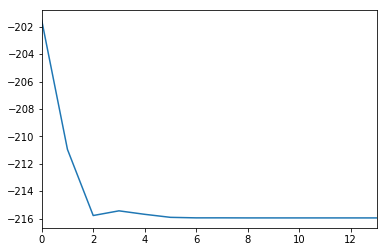

In [26]:
# Evolución de la optimización
fig = plt.figure(figsize=(6,4))
enjambre.resultados_df['mejor_valor_enjambre'].plot()

## Visualización animada del algoritmo en funcionamiento

In [27]:
# Evolución animada del PSO
def extraer_posicion(particula):
    posicion = particula.posicion
    return(posicion)

lista_df_temp = []

for i in np.arange(len(enjambre.historico_particulas)):
    posiciones = list(map(extraer_posicion, enjambre.historico_particulas[i]))
    df_temp = pd.DataFrame({"iteracion": i, "posicion": posiciones})
    lista_df_temp.append(df_temp)

df_posiciones = pd.concat(lista_df_temp)

df_posiciones[['x_0','x_1']] = pd.DataFrame(df_posiciones["posicion"].values.tolist(),
                                            index= df_posiciones.index)

In [28]:
graph_x_min, graph_y_min

(-5, -7)

In [29]:
graph_x_max, graph_y_max

(5, 7)

In [30]:
px.scatter(
    df_posiciones,
    x       = "x_0",
    y       = "x_1",
    range_x = [graph_x_min, graph_x_max],
    range_y = [graph_y_min, graph_y_max],
    animation_frame = "iteracion"
)

# Preguntas:

      
<b>1) Ejecute 7 veces el algoritmo PSO en la funcion `funcion_C` usando los siguientes parametros, e imprima los resultados en su notebook:</b>

    - n_particulas            = 50
    - n_variables             = 2
    - graph_x_min             = -5
    - graph_x_max             = 5
    - graph_y_min             = -7
    - graph_y_max             = 7
    - limites_inf             = [graph_x_min, graph_y_min]
    - limites_sup             = [graph_x_max, graph_y_max]    
    - aleatorioEsEscalar      = False
    - n_iteraciones           = 250
    - inercia                 = 0.5
    - peso_cognitivo (phi1)   = 2
    - peso_social (phi2)      = 2
    - parada_temprana         = True
    - rondas_parada           = 5
    - tolerancia_parada       = 10**-3
      
Registre la media y desviación estandard de los siguientes atributos de las optimizaciones ejecutadas: Número de iteraciones, Coordenada 0 de la posición óptima, Coordenada 1 de la posición óptima, y el valor óptimo de la mejor partícula encontrada.

Comente sus resultados en base a: la capacidad de PSO de encontrar optimos y su variabilidad en los resultados (indicados por la desviacion estandard de cada parámetro registrado). En total, para esta pregunta, debe reportar 4 promedios y 4 desviaciones estándar.

Sugerencia: Usar celdas de texto, con cabeceras de enunciados (usando ####, por ejemplo), para agrupar los bloques de código donde impriman el resultado de sus ejecuciones. En esencia, agrupar sus resultados en secciones, de la misma manera que se hizo en este notebook.

<b>2) Manteniendo los demas parámetros constantes, y colocando aleatorioEsEscalar = True, ejecute el algoritmo de PSO otras 7 veces y registre los mismos parámetros que en el ejercicio anterior. </b>    
      
<b>3) Manteniendo los demas parámetros constantes, varíe el parametro w (inercia) en el siguiente rango w = {0.1, 1, 10}. Para cada valor de w ejecute al menos 5 repeticiones y registre el valor medio y desviacion estandar del valor óptimo de la mejor partícula encontrada </b>
         
Analice los resultados, observe gráficamente la convergencia de las partículas en la animación y explique como influye la inercia en la búsqueda de optimos en el algoritmo PSO.
        


## 4) Análisis de un caso de dimensiones superiores

Para verificar que su código funciona para el caso de posiciones n-dimensionales, se pide realizar la siguiente optimización, usando la función `funcion_B`. Optimizar y mostrar los resultados de al menos 2 ejecuciones, como mínimo.


In [12]:
#No debe cambiar ninguna línea del código de esta celda.
#Su implementación debe permitir que esta celda sea ejecutada sin problemas.
enjambre2 = Enjambre(
               n_particulas = 50,
               n_variables  = 4,
               limites_inf  = [-5, -5, -5, -5],
               limites_sup  = [+5, +5, +5, +5]
            )

enjambre2.optimizar(
    funcion_objetivo = funcion_B,
    optimizacion     = "minimizar",
    aleatorioEsEscalar = False,
    n_iteraciones    = 500,
    inercia          = 0.95,
    peso_cognitivo   = 2,
    peso_social      = 2,
    parada_temprana  = True,
    rondas_parada    = 5,
    tolerancia_parada = 10**-3
)

-------------------------------------------
Función optimizada: funcion_B
Optimizado: True
Tipo de optimización: minimizar
Número de partículas: 50
Límites inferiores de cada variable: [-5 -5 -5 -5]
Límites superiores de cada variable: [5 5 5 5]
Secuencias randómicas ESCALARES para los aprendizajes cognitivo y social?: False
Duración de optimización: 4.4640583992004395
Número de iteraciones: 499
Posición óptima: [0.9729343487033644 0.006733319150247219 -0.8431650929333045
 0.9249801195526111]
Valor óptimo: 8.231755656975746



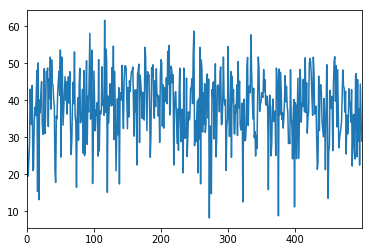

In [13]:
# Evolución de la optimización
fig2 = plt.figure(figsize=(6,4))
enjambre2.resultados_df['mejor_valor_enjambre'].plot()